In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model

In [2]:
# Load processed dataset
df = pd.read_csv("../data/improve/crop_data_pivot_log.csv")

In [3]:
# Define targets and models
elements = ["Production", "Area harvested", "Yield"]
model_names = ["ANN", "RandomForest", "LinearRegression", "XGBoost"]


📌 Evaluating Models for: Production
🔍 Evaluating: ANN
3599/3599 ━━━━━━━━━━━━━━━━━━━━ 3s 677us/step
✅ MSE: 0.0672 | R²: 0.9930


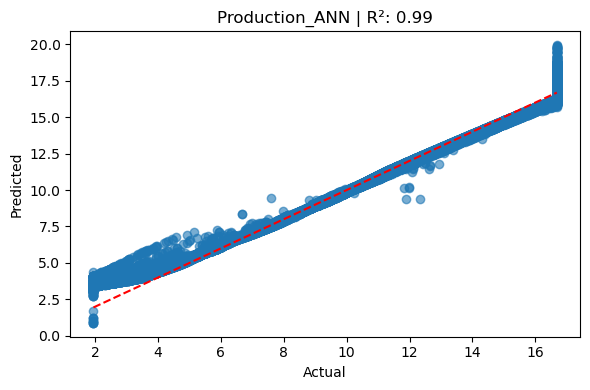

🔍 Evaluating: RandomForest
✅ MSE: 0.0022 | R²: 0.9998


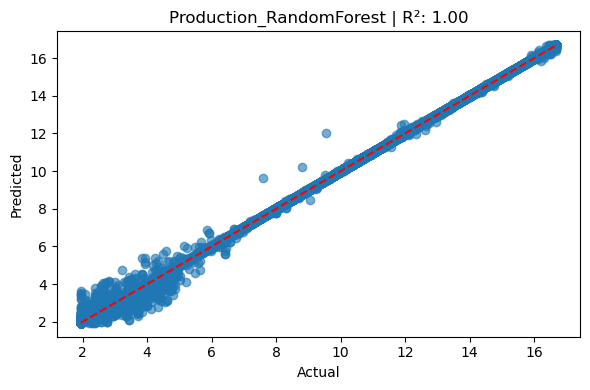

🔍 Evaluating: LinearRegression
✅ MSE: 0.0414 | R²: 0.9957


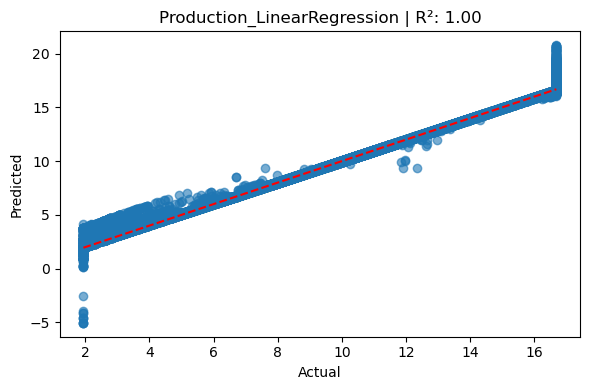

🔍 Evaluating: XGBoost
✅ MSE: 0.0101 | R²: 0.9990


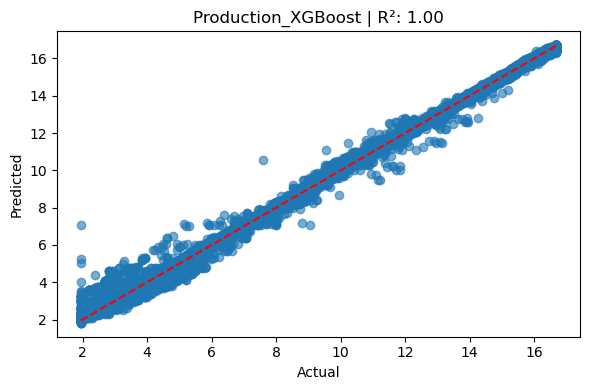


📌 Evaluating Models for: Area harvested
🔍 Evaluating: ANN
3599/3599 ━━━━━━━━━━━━━━━━━━━━ 3s 646us/step
✅ MSE: 0.0852 | R²: 0.9909


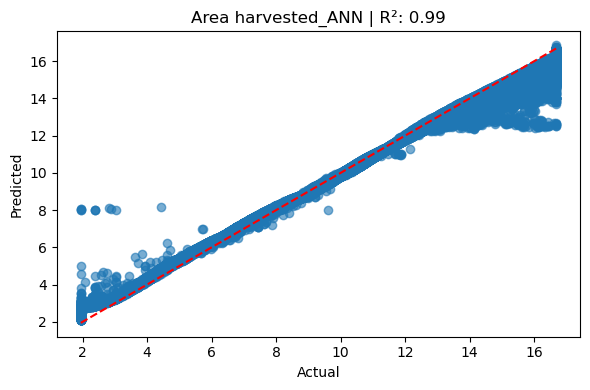

🔍 Evaluating: RandomForest
✅ MSE: 0.0116 | R²: 0.9988


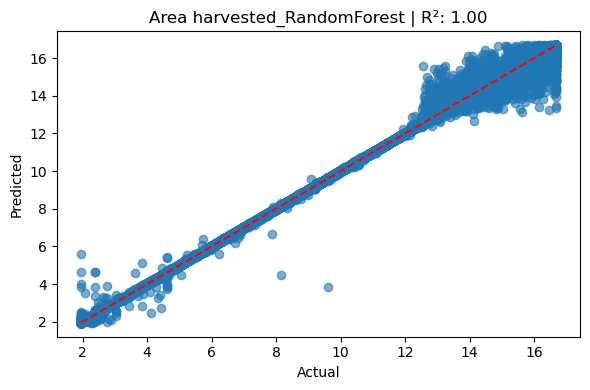

🔍 Evaluating: LinearRegression
✅ MSE: 0.0422 | R²: 0.9955


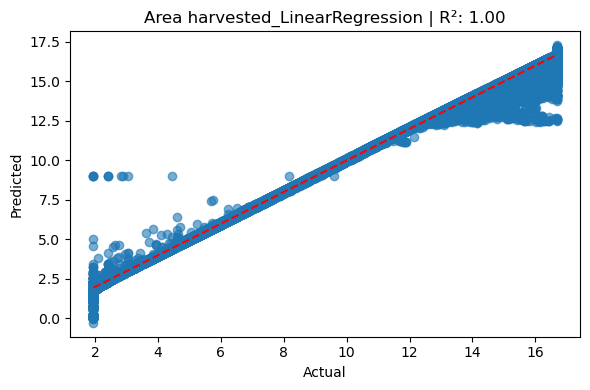

🔍 Evaluating: XGBoost
✅ MSE: 0.0208 | R²: 0.9978


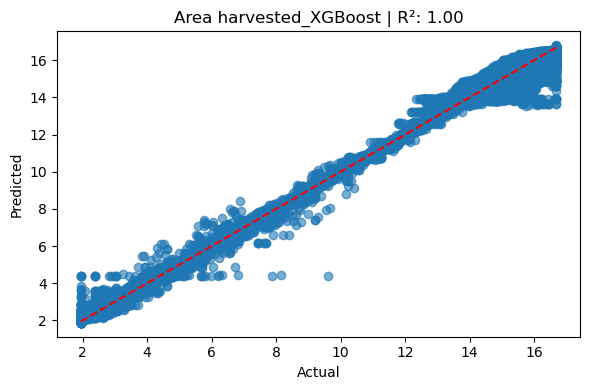


📌 Evaluating Models for: Yield
🔍 Evaluating: ANN
3599/3599 ━━━━━━━━━━━━━━━━━━━━ 2s 550us/step
✅ MSE: 0.0287 | R²: 0.9853


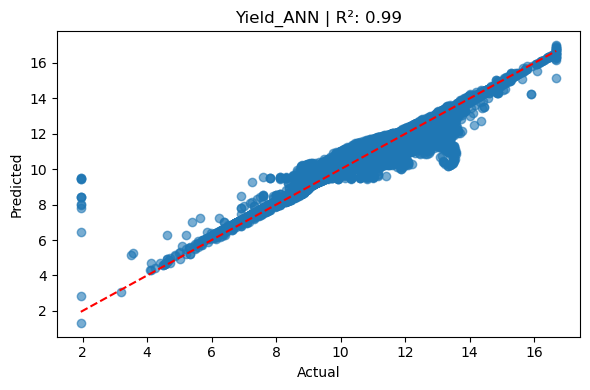

🔍 Evaluating: RandomForest
✅ MSE: 0.0205 | R²: 0.9895


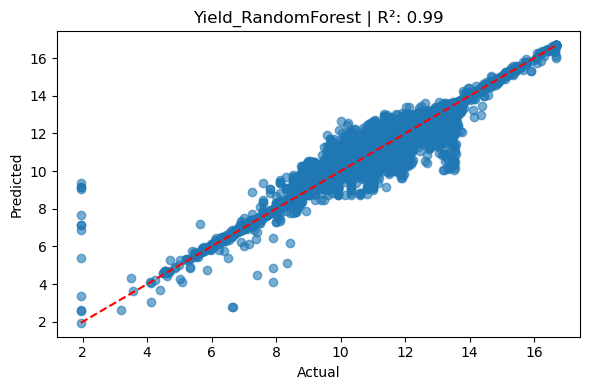

🔍 Evaluating: LinearRegression
✅ MSE: 0.0426 | R²: 0.9782


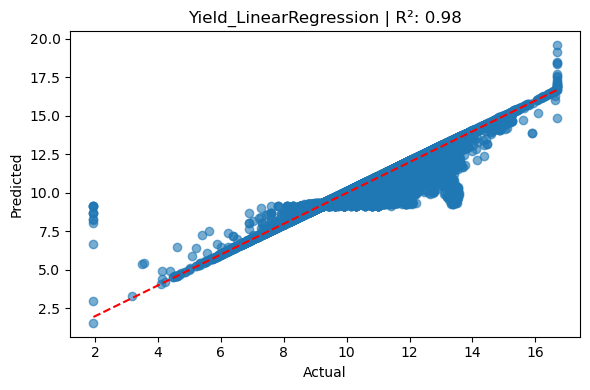

🔍 Evaluating: XGBoost
✅ MSE: 0.0315 | R²: 0.9839


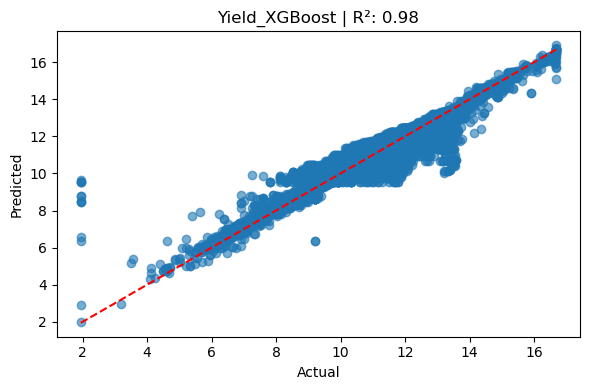


📊 All Evaluation Results:


,Target,Model,MSE,R2
5,Area harvested,RandomForest,0.011598,0.998755
7,Area harvested,XGBoost,0.020844,0.997762
6,Area harvested,LinearRegression,0.042174,0.995473
4,Area harvested,ANN,0.085209,0.990853
1,Production,RandomForest,0.002192,0.999772
3,Production,XGBoost,0.010073,0.998951
2,Production,LinearRegression,0.041392,0.995688
0,Production,ANN,0.067210,0.992999
9,Yield,RandomForest,0.020535,0.989483
8,Yield,ANN,0.028656,0.985324


In [4]:
# Container to store results
evaluation_results = []

# Evaluate each model for each target
for element in elements:
    print(f"\n📌 Evaluating Models for: {element}")

    # Define features dynamically
    feature_cols = [col for col in elements if col != element] + ["Year"]
    data = df.dropna(subset=[element] + feature_cols).copy()
    
    X = data[feature_cols]
    y = data[element]

    # Split before scaling
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for model_name in model_names:
        print(f"🔍 Evaluating: {model_name}")
        model_key = f"{element}_{model_name}"

        try:
            if model_name == "ANN":
                model = load_model(f"../models/{model_key}.h5", compile=False)
                scaler = joblib.load(f"../models/{model_key}_scaler.pkl")
            else:
                bundle = joblib.load(f"../models/{model_key}.pkl")
                model = bundle["model"]
                scaler = bundle["scaler"]

            # Scale test features
            X_test_scaled = scaler.transform(X_test)

            # Predict
            if model_name == "ANN":
                y_pred = model.predict(X_test_scaled).flatten()
            else:
                y_pred = model.predict(X_test_scaled)

            # Evaluate
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            evaluation_results.append({
                "Target": element,
                "Model": model_name,
                "MSE": mse,
                "R2": r2
            })

            print(f"✅ MSE: {mse:.4f} | R²: {r2:.4f}")

            # Scatter plot
            plt.figure(figsize=(6, 4))
            plt.scatter(y_test, y_pred, alpha=0.6)
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
            plt.title(f"{model_key} | R²: {r2:.2f}")
            plt.xlabel("Actual")
            plt.ylabel("Predicted")
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"❌ Failed to load or evaluate {model_key}: {e}")

# 📄 Convert results to DataFrame
results_df = pd.DataFrame(evaluation_results)
results_df = results_df.sort_values(by=["Target", "R2"], ascending=[True, False])
print("\n📊 All Evaluation Results:")
display(results_df)


C:\Users\User\AppData\Local\Temp\ipykernel_5332\4185782308.py:11: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\User\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


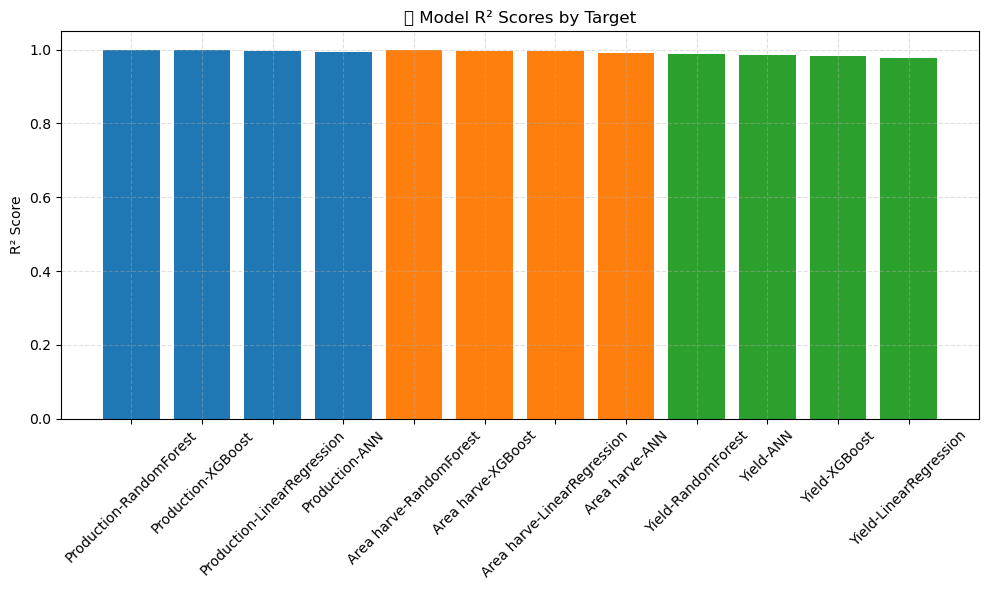

In [5]:
# Bar Plot of R² per model and target
plt.figure(figsize=(10, 6))
for target in elements:
    subset = results_df[results_df["Target"] == target]
    plt.bar([f"{target[:10]}-{model}" for model in subset["Model"]],
            subset["R2"], label=target)

plt.xticks(rotation=45)
plt.ylabel("R² Score")
plt.title("📈 Model R² Scores by Target")
plt.tight_layout()
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()